## Loading Dataset

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [2]:
df = pd.read_csv('imdb_ts.csv')
df

,id,0,1,2,3,4,5,6,7,8,...,93,94,95,96,97,98,99,rating,genre,rating_category
0,tt0062622,57057.0,65469.0,71642.0,73025.0,74060.0,49472.0,30258.0,28036.0,25824.0,...,10709.0,11042.0,11388.0,11847.0,12404.0,13679.0,15056.0,8.3,"['Adventure', 'Sci-Fi']",High
1,tt0064816,1923.0,2422.0,2853.0,2947.0,3054.0,2844.0,2617.0,1998.0,1277.0,...,637.0,734.0,857.0,785.0,724.0,713.0,699.0,7.1,"['Crime', 'Drama', 'Romance']",High
2,tt0088178,332925.0,302503.0,267264.0,261879.0,256608.0,196530.0,112728.0,117384.0,123024.0,...,6784.0,7253.0,7776.0,9632.0,11212.0,9010.0,6431.0,8.7,"['Documentary', 'Music']",High
3,tt0145487,682857.0,407032.0,78058.0,81732.0,86772.0,83724.0,79940.0,39656.0,6974.0,...,21094.0,10995.0,1586.0,1421.0,1177.0,970.0,802.0,7.4,"['Action', 'Adventure', 'Sci-Fi']",High
4,tt0359950,7813372.0,6274563.0,4781588.0,4655046.0,4535301.0,4650574.0,4758452.0,4069428.0,3471755.0,...,88635.0,68347.0,45367.0,28915.0,15494.0,16155.0,16853.0,7.3,"['Adventure', 'Comedy', 'Drama']",High
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1129,tt9731534,1077363.0,1061148.0,1043451.0,912840.0,738595.0,508118.0,296236.0,318113.0,341113.0,...,2396.0,2425.0,2461.0,2223.0,1920.0,1991.0,2051.0,6.4,"['Horror', 'Mystery', 'Thriller']",Medium
1130,tt9735462,56775.0,57750.0,58828.0,53549.0,48484.0,37340.0,19243.0,30804.0,55897.0,...,739.0,618.0,488.0,636.0,883.0,904.0,920.0,6.3,"['Biography', 'Comedy', 'Drama']",Medium
1131,tt9764362,3595005.0,3401235.0,3221227.0,2645775.0,2188725.0,1681250.0,1030698.0,1138724.0,1290788.0,...,345246.0,257388.0,182883.0,165311.0,144119.0,128009.0,111756.0,7.2,"['Comedy', 'Horror', 'Thriller']",High
1132,tt9784798,528167.0,617409.0,696127.0,741481.0,802782.0,527997.0,177249.0,141753.0,100026.0,...,10108.0,10511.0,10878.0,7491.0,3752.0,5237.0,6592.0,7.4,"['Biography', 'Drama', 'History']",High


#some suggestion to add
1) maybe adding the log transformation to reduce skewness -{copy chiara preprocessing steps}
2) scaling the data using StandardScaler
3) First 50 time steps for clustering
4) add PCA

In [3]:
# Prepare the data
time_series_data = df.iloc[:,1:101].values
time_series_data = np.log1p(time_series_data)
scaler = StandardScaler()
scaled_data = scaler.fit_transform(time_series_data.T).T # Chiara's suggestion: z-score per serie

## Dynamic Time Warping

In [4]:
%%time
import numpy as np
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from scipy.spatial.distance import squareform
from tslearn.metrics import cdist_dtw

# -------------------------------------------------------
# 1. Compute DTW distance matrix with Sakoe–Chiba band
# -------------------------------------------------------

band_width = 10   # 10% of 100 days

dtw_dist_matrix = cdist_dtw(
    scaled_data,
    global_constraint="sakoe_chiba",
    sakoe_chiba_radius=band_width
)

# Convert full matrix → condensed vector
condensed_dtw = squareform(dtw_dist_matrix)

# -------------------------------------------------------
# 2. Perform hierarchical clustering using DTW distances
# -------------------------------------------------------

linked = linkage(condensed_dtw, method='average')

CPU times: total: 10min 33s
Wall time: 11min 35s


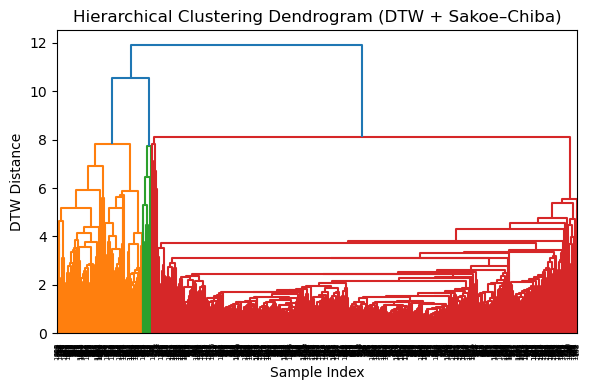

In [6]:
# -------------------------------------------------------
# 3. Plot dendrogram
# -------------------------------------------------------

plt.figure(figsize=(6, 4))
dendrogram(
    linked,
    orientation='top',
    distance_sort='descending',
    show_leaf_counts=True
)
plt.title('Hierarchical Clustering Dendrogram (DTW + Sakoe–Chiba)')
plt.xlabel('Sample Index')
plt.ylabel('DTW Distance')
plt.tight_layout()
plt.savefig('dendrogram_dtw.png')

# -------------------------------------------------------
# 4. Assign clusters (example: 4 clusters)
# -------------------------------------------------------

cluster_labels = fcluster(linked, t=4, criterion='maxclust')

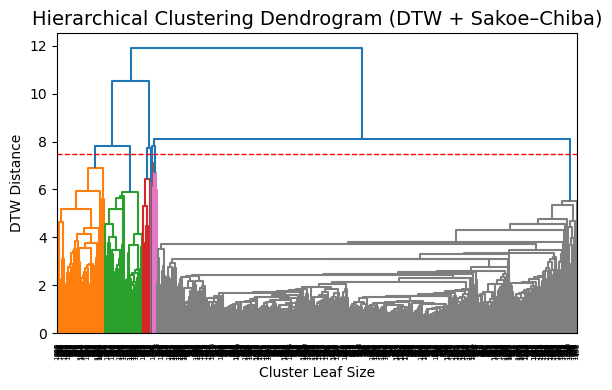

In [ ]:
# -------------------------------------------------------
# 3. Plot dendrogram with cut at 7.5
# -------------------------------------------------------

plt.figure(figsize=(6, 4))

ddata = dendrogram(
    linked,
    orientation='top',
    distance_sort='descending',
    show_leaf_counts=True,
    color_threshold=7.5      # <-- cut at 7.5
)

# Draw horizontal cut line
plt.axhline(y=7.5, color='red', linestyle='--', linewidth=1)

# Title with fontsize 14
plt.title('Hierarchical Clustering Dendrogram (DTW + Sakoe–Chiba)', fontsize=12)

# Compute branch sizes (cluster sizes)
# Each leaf is a sample, so count leaves under each branch
icoord = ddata['icoord']
dcoord = ddata['dcoord']
leaf_counts = ddata['leaves']

# Replace x‑ticks with cluster sizes
plt.xticks(
    ticks=plt.xticks()[0],
    labels=[str(c) for c in leaf_counts],   # number of samples in each leaf
    rotation=90
)

plt.xlabel('Cluster Leaf Size')
plt.ylabel('DTW Distance')
plt.tight_layout()
plt.savefig('dendrogram_dtw.png')
plt.show()

# -------------------------------------------------------
# 4. Assign clusters (example: 4 clusters)
# -------------------------------------------------------

cluster_labels = fcluster(linked, t=7.5, criterion='distance')


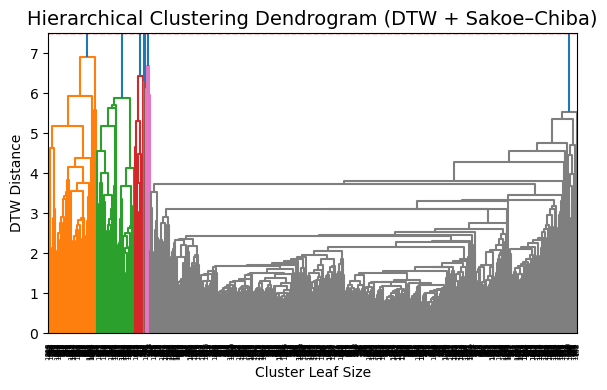

In [8]:
# -------------------------------------------------------
# 3. Plot cropped dendrogram (up to distance 7.5)
# -------------------------------------------------------

plt.figure(figsize=(6, 4))

ddata = dendrogram(
    linked,
    orientation='top',
    distance_sort='descending',
    show_leaf_counts=True,
    color_threshold=7.5
)

# Draw horizontal cut line
plt.axhline(y=7.5, color='red', linestyle='--', linewidth=1)

# Crop the y-axis to show only up to 7.5
plt.ylim(0, 7.5)

# Title and labels
plt.title('Hierarchical Clustering Dendrogram (DTW + Sakoe–Chiba)', fontsize=14)
plt.xlabel('Cluster Leaf Size')
plt.ylabel('DTW Distance')
plt.tight_layout()
plt.savefig('dendrogram_dtw_cropped.png')
plt.show()


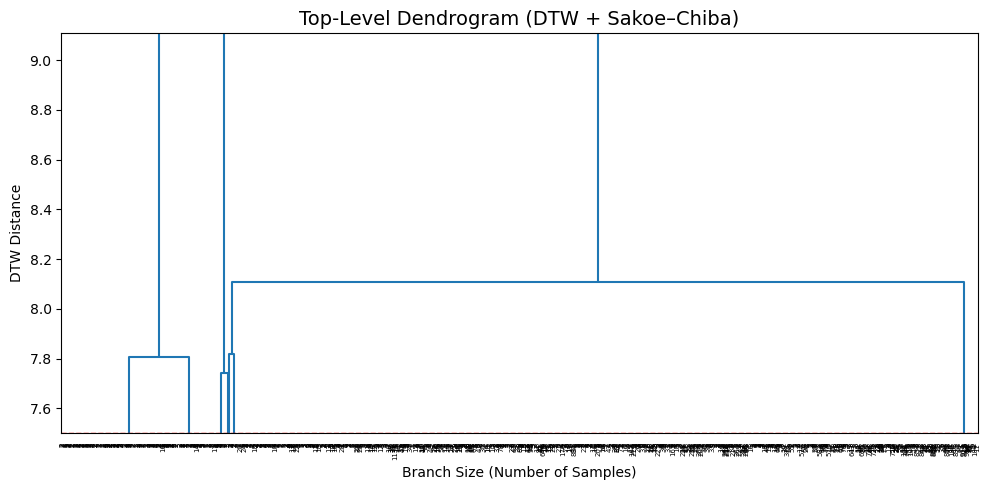

In [9]:
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import squareform

# Assuming 'linked' is your linkage matrix

plt.figure(figsize=(10, 5))

# Plot dendrogram and capture its structure
ddata = dendrogram(
    linked,
    orientation='top',
    distance_sort='descending',
    show_leaf_counts=False,       # We’ll customize x-ticks manually
    color_threshold=7.5           # Cut line for visual separation
)

# Draw horizontal cut line
plt.axhline(y=7.5, color='red', linestyle='--', linewidth=1)

# Crop bottom half of dendrogram
plt.ylim(7.5, max(ddata['dcoord'], key=max)[-1] + 1)

# Compute branch sizes (number of leaves under each x-tick)
leaf_sizes = [linked[i, 3] for i in range(len(linked))]  # column 3 = number of samples merged

# Get x-tick positions from dendrogram
xtick_positions = ddata['icoord']
xtick_labels = [int(linked[i, 3]) for i in range(len(xtick_positions))]

# Set custom x-ticks
plt.xticks(
    ticks=[(x[1] + x[2]) / 2 for x in xtick_positions],  # center of each branch
    labels=[str(size) for size in xtick_labels],
    rotation=90
)

# Labels and title
plt.title('Top-Level Dendrogram (DTW + Sakoe–Chiba)', fontsize=14)
plt.xlabel('Branch Size (Number of Samples)')
plt.ylabel('DTW Distance')
plt.tight_layout()
plt.savefig('dendrogram_top_only.png')
plt.show()


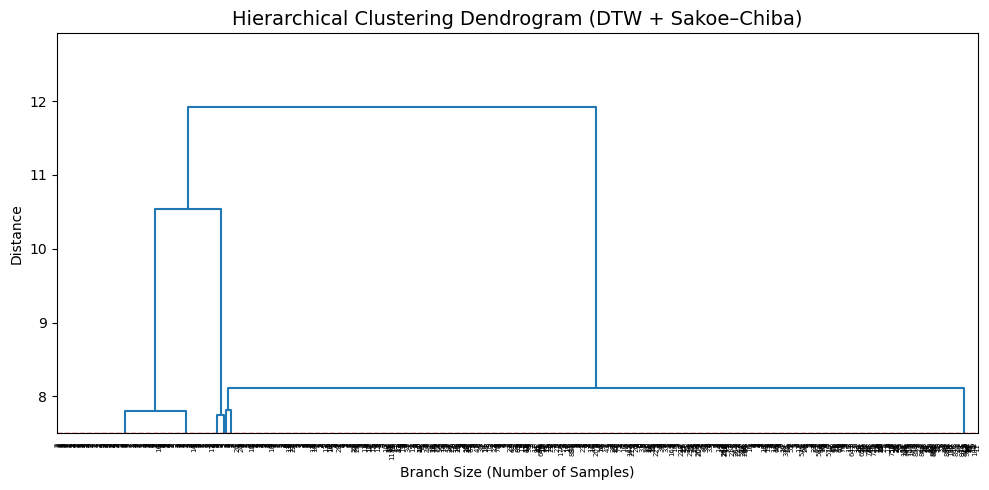

In [10]:
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage
import numpy as np

# Assuming 'linked' is your linkage matrix from DTW distances

plt.figure(figsize=(10, 5))

# Plot dendrogram and capture structure
ddata = dendrogram(
    linked,
    orientation='top',
    distance_sort='descending',
    show_leaf_counts=False,
    color_threshold=7.5
)

# Draw horizontal cut line
plt.axhline(y=7.5, color='red', linestyle='--', linewidth=1)

# Crop to show only top portion
plt.ylim(7.5, max([max(d) for d in ddata['dcoord']]) + 1)

# Compute branch sizes from linkage matrix (column 3 = number of samples merged)
branch_sizes = [int(linked[i, 3]) for i in range(len(linked))]

# Get x-tick positions from dendrogram coordinates
xtick_positions = [(x[1] + x[2]) / 2 for x in ddata['icoord']]

# Set x-ticks to branch sizes
plt.xticks(
    ticks=xtick_positions,
    labels=[str(size) for size in branch_sizes],
    rotation=90
)

# Final labels and title
plt.title('Hierarchical Clustering Dendrogram (DTW + Sakoe–Chiba)', fontsize=14)
plt.xlabel('Branch Size (Number of Samples)')
plt.ylabel('Distance')
plt.tight_layout()
plt.savefig('dendrogram_top_branchsize.png')
plt.show()


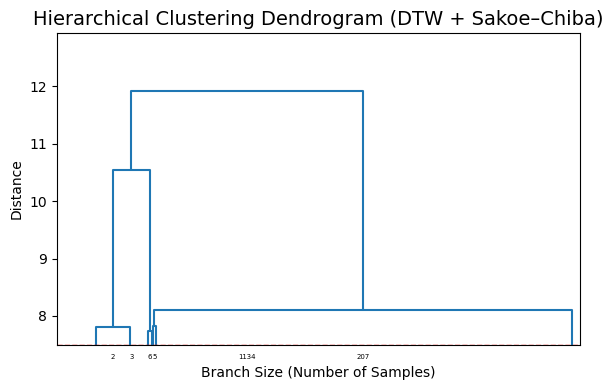

In [11]:
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage
import numpy as np

# Assuming 'linked' is your linkage matrix

plt.figure(figsize=(6, 4))

# Plot dendrogram and capture structure
ddata = dendrogram(
    linked,
    orientation='top',
    distance_sort='descending',
    show_leaf_counts=False,
    color_threshold=7.5
)

# Draw horizontal cut line
plt.axhline(y=7.5, color='red', linestyle='--', linewidth=1)

# Crop to show only top portion
plt.ylim(7.5, max([max(d) for d in ddata['dcoord']]) + 1)

# Extract top-level branches above the cut
top_branches = []
for i, (x, y) in enumerate(zip(ddata['icoord'], ddata['dcoord'])):
    if max(y) > 7.5:  # only branches above the cut
        center_x = (x[1] + x[2]) / 2
        cluster_size = int(linked[i, 3])  # number of samples merged
        top_branches.append((center_x, cluster_size))

# Set x-ticks to cluster sizes
xtick_positions = [x for x, _ in top_branches]
xtick_labels = [str(size) for _, size in top_branches]

plt.xticks(
    ticks=xtick_positions,
    labels=xtick_labels,
    rotation=0
)

# Final labels and title
plt.title('Hierarchical Clustering Dendrogram (DTW + Sakoe–Chiba)', fontsize=14)
plt.xlabel('Branch Size (Number of Samples)')
plt.ylabel('Distance')
plt.tight_layout()
plt.savefig('dendrogram_top_branchsize_fixed.png')
plt.show()


ValueError: The number of FixedLocator locations (6), usually from a call to set_ticks, does not match the number of labels (7).

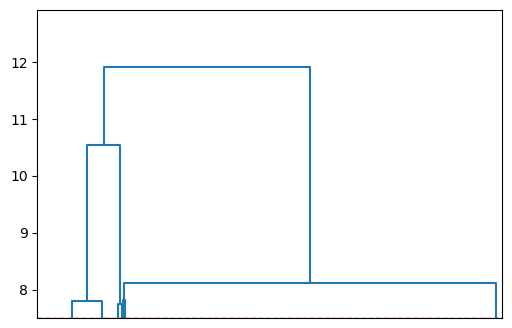

In [12]:
plt.figure(figsize=(6, 4))

ddata = dendrogram(
    linked,
    orientation='top',
    distance_sort='descending',
    show_leaf_counts=False,
    color_threshold=7.5
)

# Horizontal cut line
cut = 7.5
plt.axhline(y=cut, color='red', linestyle='--', linewidth=1)

# Crop to show only top part
plt.ylim(cut, max(max(dc) for dc in ddata['dcoord']) + 1)

top_branches = []

# ddata['icoord'] and ddata['dcoord'] have same length
for icoord_seg, dcoord_seg in zip(ddata['icoord'], ddata['dcoord']):
    # each segment is like [x1,x2,x3,x4], [y1,y2,y3,y4]
    # the merge is at the middle two points (x2,x3) at height y2,y3
    y_merge = max(dcoord_seg[1], dcoord_seg[2])
    if y_merge >= cut:
        x_center = (icoord_seg[1] + icoord_seg[2]) / 2.0
        top_branches.append(x_center)

# Now we need the sizes of the clusters at the cut:
from scipy.cluster.hierarchy import fcluster

cluster_labels = fcluster(linked, t=cut, criterion='distance')

# Count sizes of clusters
unique_clusters, counts = np.unique(cluster_labels, return_counts=True)

# We have as many top branches as clusters above the cut
# Sort x positions and align them with sorted cluster sizes
top_branches_sorted = sorted(top_branches)
cluster_sizes_sorted = sorted(counts)  # or keep as is if you want original order

plt.xticks(
    ticks=top_branches_sorted,
    labels=[str(s) for s in cluster_sizes_sorted],
    rotation=0,
    ha='center'
)

plt.title('Hierarchical Clustering Dendrogram (DTW + Sakoe–Chiba)', fontsize=14)
plt.xlabel('Branch Size (Number of Samples)')
plt.ylabel('Distance')
plt.tight_layout()
plt.savefig('dendrogram_top_branchsize_aligned.png')
plt.show()


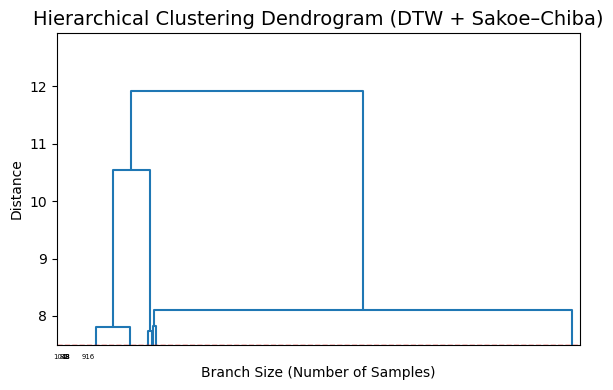

In [5]:
from scipy.cluster.hierarchy import dendrogram, fcluster
import numpy as np
import matplotlib.pyplot as plt

cut = 7.5

plt.figure(figsize=(6, 4))

ddata = dendrogram(
    linked,
    orientation='top',
    distance_sort='descending',
    show_leaf_counts=False,
    color_threshold=cut
)

# Horizontal cut line
plt.axhline(y=cut, color='red', linestyle='--', linewidth=1)

# Crop to show only top part
plt.ylim(cut, max(max(dc) for dc in ddata['dcoord']) + 1)

# --- Compute cluster sizes and x-positions of clusters ---

# cluster labels for each original point (in original index order)
cluster_labels = fcluster(linked, t=cut, criterion='distance')

# order of leaves in the dendrogram
leaves = ddata['leaves']          # indices of samples in the order they appear on x-axis
x_leaf_positions = np.arange(len(leaves))  # x positions of each leaf

# map: cluster_id -> list of x positions of its leaves
cluster_to_x = {}
for leaf_idx, x in zip(leaves, x_leaf_positions):
    c = cluster_labels[leaf_idx]          # cluster of this sample
    cluster_to_x.setdefault(c, []).append(x)

# for each cluster: center position and size
cluster_centers = []
cluster_sizes = []
for c, xs in cluster_to_x.items():
    cluster_centers.append(np.mean(xs))
    cluster_sizes.append(len(xs))

# sort by x so labels are left-to-right
sorted_idx = np.argsort(cluster_centers)
cluster_centers = np.array(cluster_centers)[sorted_idx]
cluster_sizes = np.array(cluster_sizes)[sorted_idx]

# --- Set x-ticks to cluster centers, labels to cluster sizes ---

plt.xticks(
    ticks=cluster_centers,
    labels=[str(s) for s in cluster_sizes],
    rotation=0,
    ha='center'
)

plt.title('Hierarchical Clustering Dendrogram (DTW + Sakoe–Chiba)', fontsize=14)
plt.xlabel('Branch Size (Number of Samples)')
plt.ylabel('Distance')
plt.tight_layout()
plt.savefig('dendrogram_top_branchsize_aligned.png')
plt.show()


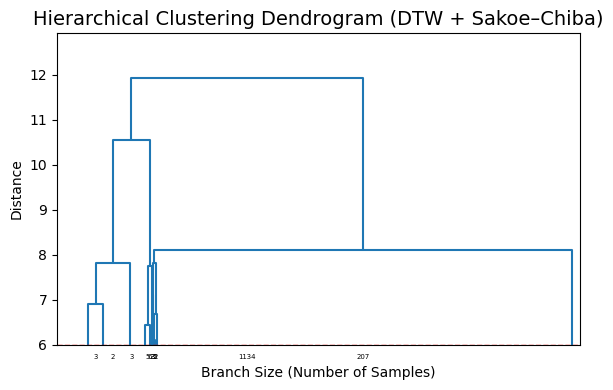

CPU times: total: 1.36 s
Wall time: 1.53 s


In [6]:
%%time
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage
import numpy as np

# Assuming 'linked' is your linkage matrix

plt.figure(figsize=(6, 4))

# Plot dendrogram and capture structure
ddata = dendrogram(
    linked,
    orientation='top',
    distance_sort='descending',
    show_leaf_counts=False,
    color_threshold=6
)

# Draw horizontal cut line
plt.axhline(y=6, color='red', linestyle='--', linewidth=1)

# Crop to show only top portion
plt.ylim(6, max([max(d) for d in ddata['dcoord']]) + 1)

# Extract top-level branches above the cut
top_branches = []
for i, (x, y) in enumerate(zip(ddata['icoord'], ddata['dcoord'])):
    if max(y) > 6:  # only branches above the cut
        center_x = (x[1] + x[2]) / 2
        cluster_size = int(linked[i, 3])  # number of samples merged
        top_branches.append((center_x, cluster_size))

# Set x-ticks to cluster sizes
xtick_positions = [x for x, _ in top_branches]
xtick_labels = [str(size) for _, size in top_branches]

plt.xticks(
    ticks=xtick_positions,
    labels=xtick_labels,
    rotation=0
)

# Final labels and title
plt.title('Hierarchical Clustering Dendrogram (DTW + Sakoe–Chiba)', fontsize=14)
plt.xlabel('Branch Size (Number of Samples)')
plt.ylabel('Distance')
plt.tight_layout()
plt.savefig('dendrogram_top_branchsize_fixed.png')
plt.show()


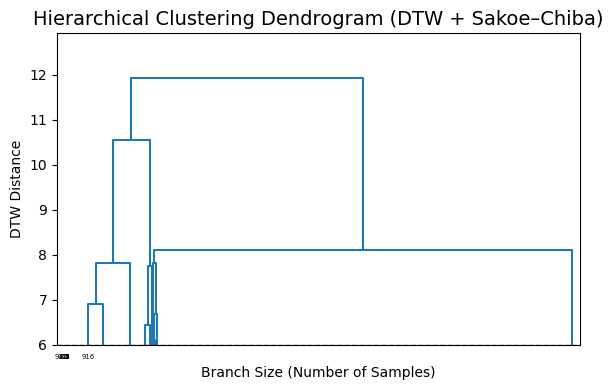

CPU times: total: 1.64 s
Wall time: 2.02 s


In [7]:
%%time
import matplotlib.pyplot as plt
import numpy as np
from scipy.cluster.hierarchy import dendrogram, fcluster

# Set cut threshold
cut = 6

plt.figure(figsize=(6, 4))

# Plot dendrogram and capture structure
ddata = dendrogram(
    linked,
    orientation='top',
    distance_sort='descending',
    show_leaf_counts=False,
    color_threshold=cut
)

# Draw horizontal cut line
plt.axhline(y=cut, color='red', linestyle='--', linewidth=1)

# Crop to show only top part
plt.ylim(cut, max(max(dc) for dc in ddata['dcoord']) + 1)

# Get cluster labels at cut height
cluster_labels = fcluster(linked, t=cut, criterion='distance')

# Get leaf order and x positions
leaves = ddata['leaves']
x_leaf_positions = np.arange(len(leaves))

# Map cluster → x positions of its leaves
cluster_to_x = {}
for leaf_idx, x in zip(leaves, x_leaf_positions):
    c = cluster_labels[leaf_idx]
    cluster_to_x.setdefault(c, []).append(x)

# Compute cluster centers and sizes
cluster_centers = []
cluster_sizes = []
for c, xs in cluster_to_x.items():
    cluster_centers.append(np.mean(xs))
    cluster_sizes.append(len(xs))

# Sort by x position for clean left-to-right labeling
sorted_idx = np.argsort(cluster_centers)
cluster_centers = np.array(cluster_centers)[sorted_idx]
cluster_sizes = np.array(cluster_sizes)[sorted_idx]

# Set x-ticks to cluster centers, labels to cluster sizes
plt.xticks(
    ticks=cluster_centers,
    labels=[str(s) for s in cluster_sizes],
    rotation=0,
    ha='center'
)

# Final labels and title
plt.title('Hierarchical Clustering Dendrogram (DTW + Sakoe–Chiba)', fontsize=14)
plt.xlabel('Branch Size (Number of Samples)')
plt.ylabel('DTW Distance')
plt.tight_layout()
plt.savefig('dendrogram_colored_branchsize_cut6.png')
plt.show()


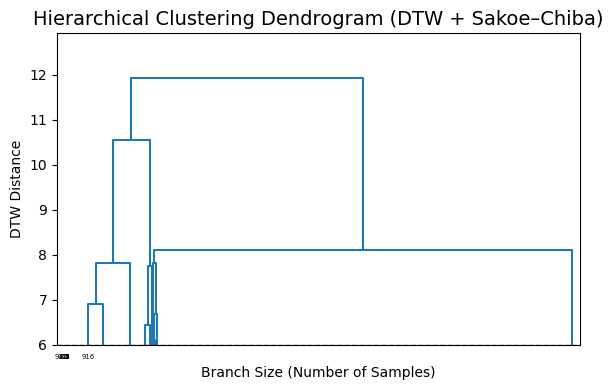

In [8]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.cluster.hierarchy import dendrogram, fcluster

# Set cut threshold
cut = 6

plt.figure(figsize=(6, 4))

# Plot dendrogram and capture structure
ddata = dendrogram(
    linked,
    orientation='top',
    distance_sort='descending',
    show_leaf_counts=False,
    color_threshold=cut
)

# Draw horizontal cut line
plt.axhline(y=cut, color='red', linestyle='--', linewidth=1)

# Crop to show only top part
plt.ylim(cut, max(max(dc) for dc in ddata['dcoord']) + 1)

# Get cluster labels at cut height
cluster_labels = fcluster(linked, t=cut, criterion='distance')

# Get leaf order and x positions
leaves = ddata['leaves']
x_leaf_positions = np.arange(len(leaves))

# Map cluster → x positions of its leaves
cluster_to_x = {}
for leaf_idx, x in zip(leaves, x_leaf_positions):
    c = cluster_labels[leaf_idx]
    cluster_to_x.setdefault(c, []).append(x)

# Compute cluster centers and sizes
cluster_centers = []
cluster_sizes = []
for c, xs in cluster_to_x.items():
    cluster_centers.append(np.mean(xs))
    cluster_sizes.append(len(xs))

# Sort by x position for clean left-to-right labeling
sorted_idx = np.argsort(cluster_centers)
cluster_centers = np.array(cluster_centers)[sorted_idx]
cluster_sizes = np.array(cluster_sizes)[sorted_idx]

# Set x-ticks to cluster centers, labels to cluster sizes
plt.xticks(
    ticks=cluster_centers,
    labels=[str(s) for s in cluster_sizes],
    rotation=0,
    ha='center'
)

# Final labels and title
plt.title('Hierarchical Clustering Dendrogram (DTW + Sakoe–Chiba)', fontsize=14)
plt.xlabel('Branch Size (Number of Samples)')
plt.ylabel('DTW Distance')
plt.tight_layout()
plt.savefig('dendrogram_colored_branchsize_cut6.png')
plt.show()


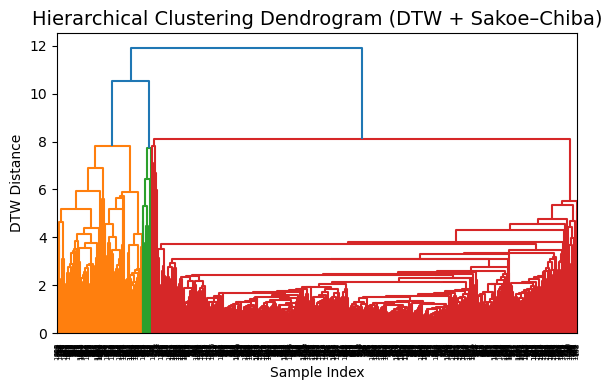

In [9]:
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram, fcluster

# -------------------------------------------------------
# 3. Plot dendrogram with automatic coloring
# -------------------------------------------------------

plt.figure(figsize=(6, 4))

ddata = dendrogram(
    linked,
    orientation='top',
    distance_sort='descending',
    show_leaf_counts=True,
    color_threshold=None  # auto-color based on maxclust
)

plt.title('Hierarchical Clustering Dendrogram (DTW + Sakoe–Chiba)', fontsize=14)
plt.xlabel('Sample Index')
plt.ylabel('DTW Distance')
plt.tight_layout()
plt.savefig('dendrogram_dtw_colored.png')
plt.show()

# -------------------------------------------------------
# 4. Assign clusters (example: 4 clusters)
# -------------------------------------------------------

cluster_labels = fcluster(linked, t=4, criterion='maxclust')


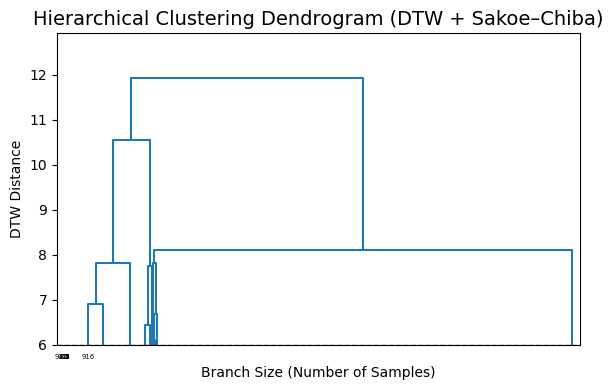

In [10]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.cluster.hierarchy import dendrogram, fcluster

# Set cut threshold
cut = 6

plt.figure(figsize=(6, 4))

# Plot dendrogram and capture structure
ddata = dendrogram(
    linked,
    orientation='top',
    distance_sort='descending',
    show_leaf_counts=False,
    color_threshold=cut
)

# Draw horizontal cut line
plt.axhline(y=cut, color='red', linestyle='--', linewidth=1)

# Crop to show only top part
plt.ylim(cut, max(max(dc) for dc in ddata['dcoord']) + 1)

# Get cluster labels at cut height
cluster_labels = fcluster(linked, t=cut, criterion='distance')

# Get leaf order and x positions
leaves = ddata['leaves']
x_leaf_positions = np.arange(len(leaves))

# Map cluster → x positions of its leaves
cluster_to_x = {}
for leaf_idx, x in zip(leaves, x_leaf_positions):
    c = cluster_labels[leaf_idx]
    cluster_to_x.setdefault(c, []).append(x)

# Compute cluster centers and sizes
cluster_centers = []
cluster_sizes = []
for c, xs in cluster_to_x.items():
    cluster_centers.append(np.mean(xs))
    cluster_sizes.append(len(xs))

# Sort by x position for clean left-to-right labeling
sorted_idx = np.argsort(cluster_centers)
cluster_centers = np.array(cluster_centers)[sorted_idx]
cluster_sizes = np.array(cluster_sizes)[sorted_idx]

# Set x-ticks to cluster centers, labels to cluster sizes
plt.xticks(
    ticks=cluster_centers,
    labels=[str(s) for s in cluster_sizes],
    rotation=0,
    ha='center'
)

# Final labels and title
plt.title('Hierarchical Clustering Dendrogram (DTW + Sakoe–Chiba)', fontsize=14)
plt.xlabel('Branch Size (Number of Samples)')
plt.ylabel('DTW Distance')
plt.tight_layout()
plt.savefig('dendrogram_colored_branchsize_cut6.png')
plt.show()


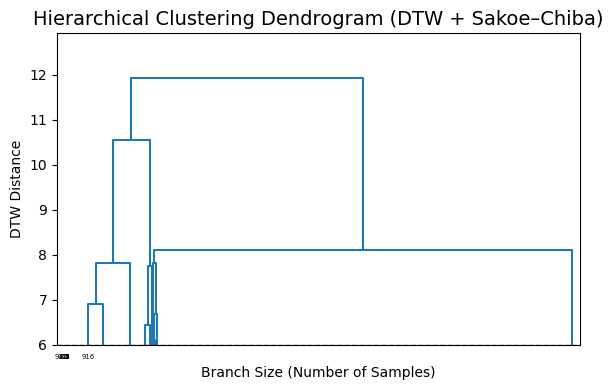

In [11]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.cluster.hierarchy import dendrogram, fcluster

cut = 6

plt.figure(figsize=(6, 4))

# Plot dendrogram and capture structure
ddata = dendrogram(
    linked,
    orientation='top',
    distance_sort='descending',
    show_leaf_counts=False,
    color_threshold=cut
)

# Draw horizontal cut line
plt.axhline(y=cut, color='red', linestyle='--', linewidth=1)

# Crop to show only top part
plt.ylim(cut, max(max(dc) for dc in ddata['dcoord']) + 1)

# Get cluster labels at cut height
cluster_labels = fcluster(linked, t=cut, criterion='distance')

# Get leaf order and x positions
leaves = ddata['leaves']
x_leaf_positions = np.arange(len(leaves))

# Map cluster → x positions of its leaves
cluster_to_x = {}
for leaf_idx, x in zip(leaves, x_leaf_positions):
    c = cluster_labels[leaf_idx]
    cluster_to_x.setdefault(c, []).append(x)

# Compute cluster centers and sizes
cluster_centers = []
cluster_sizes = []
for c, xs in cluster_to_x.items():
    cluster_centers.append(np.mean(xs))
    cluster_sizes.append(len(xs))

# Sort by x position for clean left-to-right labeling
sorted_idx = np.argsort(cluster_centers)
cluster_centers = np.array(cluster_centers)[sorted_idx]
cluster_sizes = np.array(cluster_sizes)[sorted_idx]

# Set x-ticks to cluster centers, labels to cluster sizes
plt.xticks(
    ticks=cluster_centers,
    labels=[str(s) for s in cluster_sizes],
    rotation=0,
    ha='center'
)

# Final labels and title
plt.title('Hierarchical Clustering Dendrogram (DTW + Sakoe–Chiba)', fontsize=14)
plt.xlabel('Branch Size (Number of Samples)')
plt.ylabel('DTW Distance')
plt.tight_layout()
plt.savefig('dendrogram_colored_branchsize_cut6.png')
plt.show()


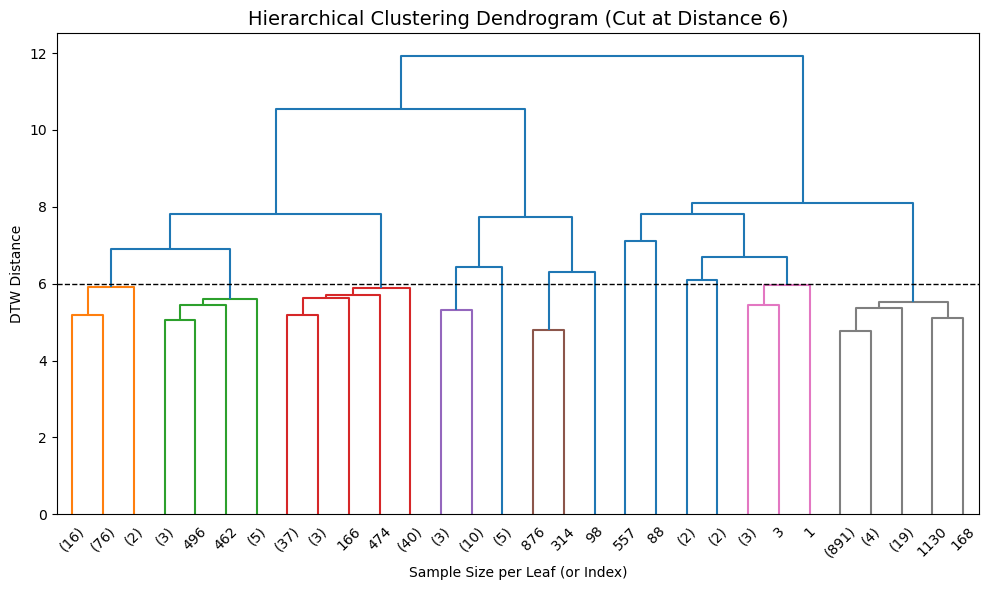

In [12]:
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram, fcluster

# 1. Define your threshold
cut_height = 6

# 2. Plot the dendrogram
plt.figure(figsize=(10, 6)) # Increased width for better label spacing

ddata = dendrogram(
    linked,
    orientation='top',
    distance_sort='descending',
    # Truncate to show 'p' clusters/leaves instead of every single sample
    truncate_mode='lastp', 
    p=30,  # Show the last 30 merged clusters to keep it readable
    show_leaf_counts=True,
    # Color threshold set to 6 as requested
    color_threshold=cut_height,
    leaf_rotation=90.,
    leaf_font_size=10.,
)

# 3. Add a horizontal line to visualize the cut at 6
plt.axhline(y=cut_height, color='black', linestyle='--', lw=1)

plt.title('Hierarchical Clustering Dendrogram (Cut at Distance 6)', fontsize=14)
plt.xlabel('Sample Size per Leaf (or Index)')
plt.ylabel('DTW Distance')

# Adjust layout and rotate x-axis labels to prevent overlap
plt.xticks(rotation=45) 
plt.tight_layout()

plt.show()

# 4. Assign clusters based on the distance threshold '6'
# Criterion 'distance' matches the visual cut at 6
cluster_labels = fcluster(linked, t=cut_height, criterion='distance')

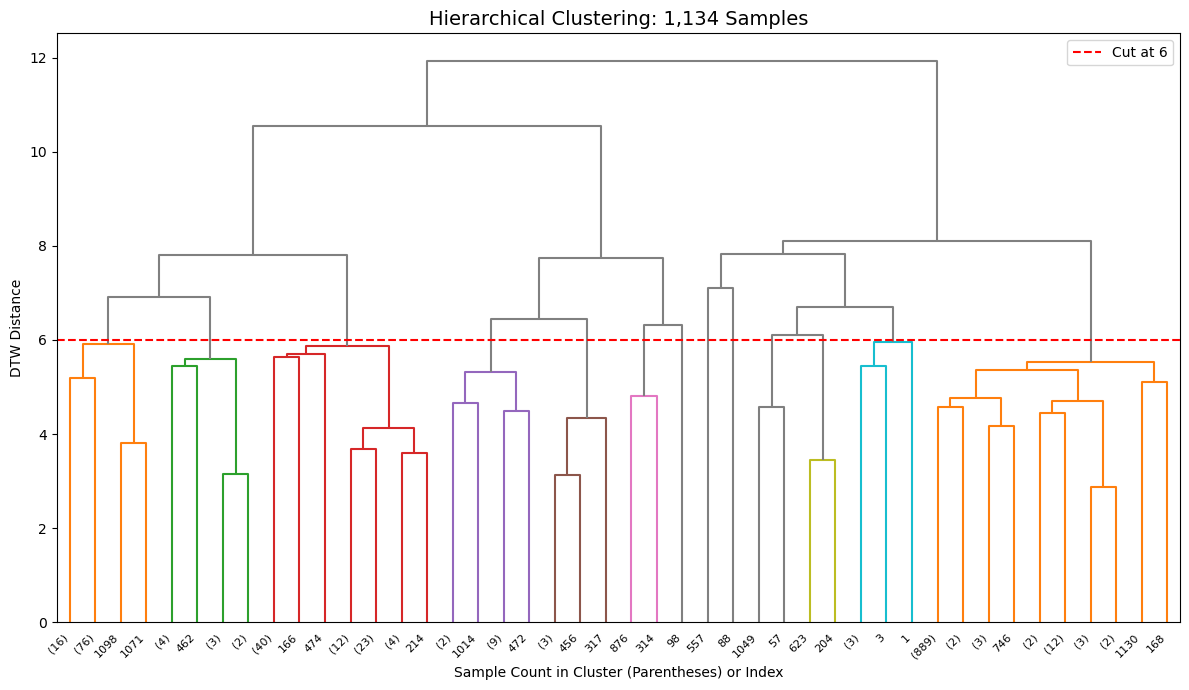

Total rows processed: 1134
Number of clusters found: 13


In [13]:
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram, fcluster

# 1. Define your cut-off
distance_threshold = 6

plt.figure(figsize=(12, 7))

# 2. Plotting the dendrogram
# We remove 'p' truncation so you can see the actual distribution, 
# but use 'level' truncation to keep it from becoming a black blur.
ddata = dendrogram(
    linked,
    orientation='top',
    distance_sort='descending',
    truncate_mode='level', 
    p=5,  # Shows 5 levels of the tree; adjust this to see more/less detail
    show_leaf_counts=True,
    color_threshold=distance_threshold, # Colors match the cut
    above_threshold_color='grey'        # Keeps the 'unclustered' top part neutral
)

# 3. Add the visual cut line
plt.axhline(y=distance_threshold, color='red', linestyle='--', label=f'Cut at {distance_threshold}')

plt.title('Hierarchical Clustering: 1,134 Samples', fontsize=14)
plt.xlabel('Sample Count in Cluster (Parentheses) or Index')
plt.ylabel('DTW Distance')

# 4. Fix the X-axis labels to prevent overlap
plt.xticks(rotation=45, ha='right') 
plt.legend()
plt.tight_layout()
plt.show()

# 5. Correct Cluster Assignment
# We use 'criterion=distance' to ensure the labels match the plot height
cluster_labels = fcluster(linked, t=distance_threshold, criterion='distance')

# Verify the count
print(f"Total rows processed: {len(cluster_labels)}")
print(f"Number of clusters found: {len(set(cluster_labels))}")

In [14]:
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram, fcluster

# 1. Configuration
distance_threshold = 6

plt.figure(figsize=(12, 7))

# 2. Define a labeling function to filter out individual indices
# This ensures we ONLY see bracketed counts like (891)
def get_only_cluster_counts(id):
    # In scipy, leaf IDs >= len(X) are clusters, < len(X) are individual indices
    if id >= len(linked) + 1:
        return "" # Hide individual indices
    return None # Let scipy use its default (bracketed) behavior for clusters

# 3. Plotting the dendrogram
ddata = dendrogram(
    linked,
    truncate_mode='lastp',
    p=20,                 # Adjust 'p' to show more or fewer clusters
    show_leaf_counts=True,
    color_threshold=distance_threshold,
    leaf_label_func=lambda id: ddata['ivl'][id] if ddata['ivl'][id].startswith('(') else "",
    above_threshold_color='grey'
)

# 4. Visual Cut and Axis limits
plt.axhline(y=distance_threshold, color='red', linestyle='--', label=f'Cut at {distance_threshold}')

# This effectively "hides" the messy detail below the threshold
plt.ylim(bottom=distance_threshold - 0.5) 

plt.title('Dendrogram: Top-Level Clusters (Only Groups)', fontsize=14)
plt.xlabel('Number of Samples in Cluster')
plt.ylabel('DTW Distance')

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

IndexError: list index out of range

<Figure size 1200x700 with 0 Axes>

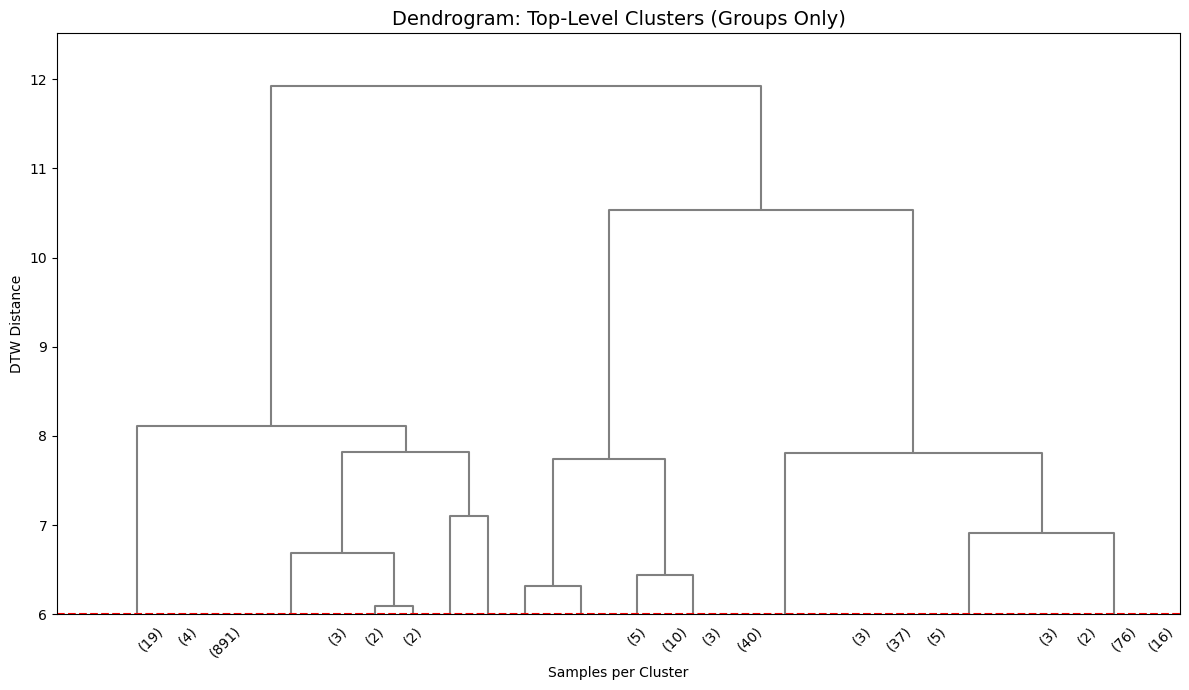

In [15]:
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram, fcluster

# 1. Configuration
distance_threshold = 6

plt.figure(figsize=(12, 7))

# 2. Logic to only show counts for groups
def count_only_labels(id):
    # n is the number of original samples
    n = len(linked) + 1
    # Check if this leaf represents a cluster (id >= n)
    if id < n:
        # It's an individual sample, return empty string
        return ""
    
    # Calculate how many samples are in this specific cluster
    # This uses the linkage matrix to find the count
    count = int(linked[id - n, 3])
    return f"({count})"

# 3. Plotting the dendrogram
ddata = dendrogram(
    linked,
    truncate_mode='lastp',
    p=30, # Shows the top 30 branches
    leaf_label_func=count_only_labels,
    color_threshold=distance_threshold,
    above_threshold_color='grey'
)

# 4. Hide everything below 6
plt.axhline(y=distance_threshold, color='red', linestyle='--', label=f'Cut at {distance_threshold}')
plt.ylim(bottom=distance_threshold) # Starts the Y-axis at 6

plt.title('Dendrogram: Top-Level Clusters (Groups Only)', fontsize=14)
plt.ylabel('DTW Distance')
plt.xlabel('Samples per Cluster')

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

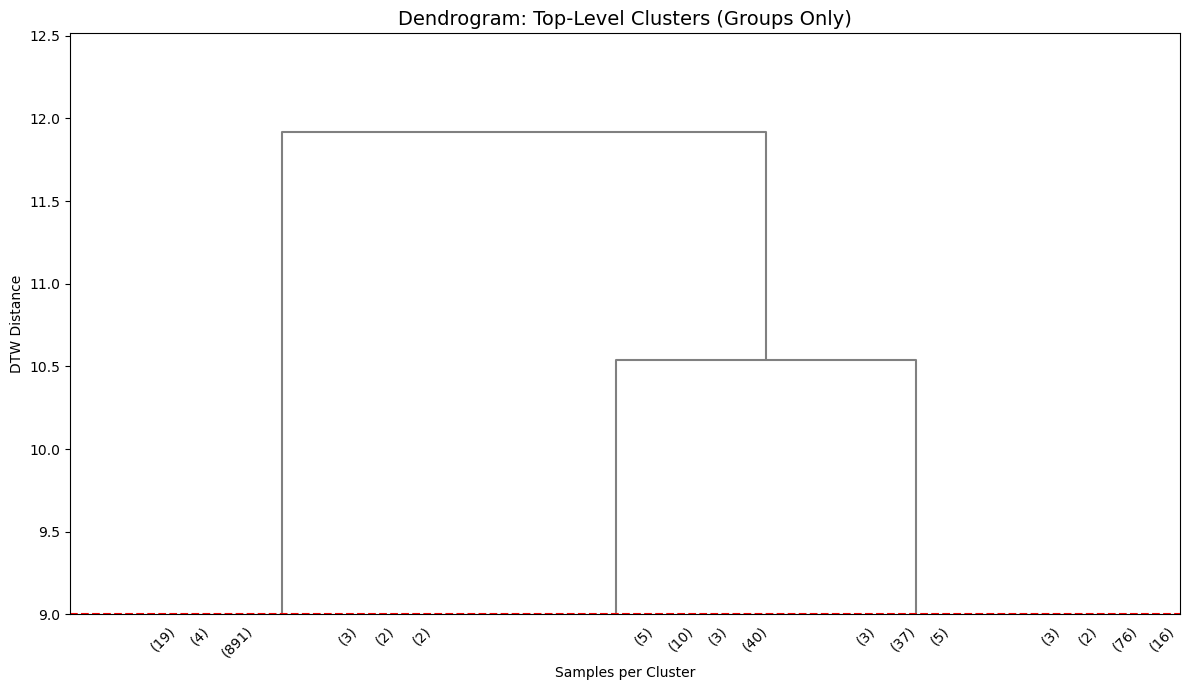

In [17]:
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram, fcluster

# 1. Configuration
distance_threshold = 9

plt.figure(figsize=(12, 7))

# 2. Logic to only show counts for groups
def count_only_labels(id):
    # n is the number of original samples
    n = len(linked) + 1
    # Check if this leaf represents a cluster (id >= n)
    if id < n:
        # It's an individual sample, return empty string
        return ""
    
    # Calculate how many samples are in this specific cluster
    # This uses the linkage matrix to find the count
    count = int(linked[id - n, 3])
    return f"({count})"

# 3. Plotting the dendrogram
ddata = dendrogram(
    linked,
    truncate_mode='lastp',
    p=30, # Shows the top 30 branches
    leaf_label_func=count_only_labels,
    color_threshold=distance_threshold,
    above_threshold_color='grey'
)

# 4. Hide everything below 6
plt.axhline(y=distance_threshold, color='red', linestyle='--', label=f'Cut at {distance_threshold}')
plt.ylim(bottom=distance_threshold) # Starts the Y-axis at 6

plt.title('Dendrogram: Top-Level Clusters (Groups Only)', fontsize=14)
plt.ylabel('DTW Distance')
plt.xlabel('Samples per Cluster')

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

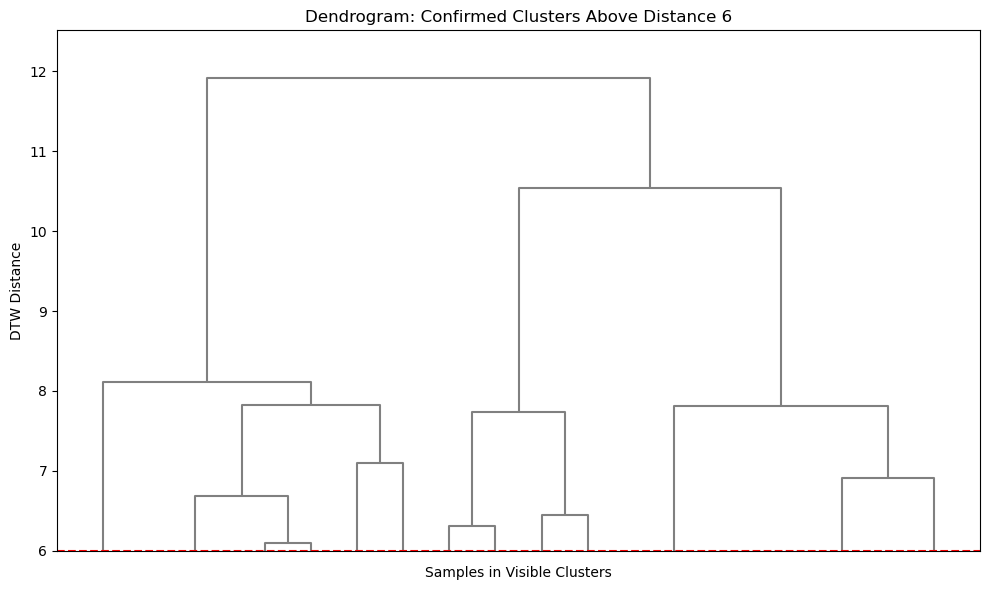

In [18]:
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram

# 1. Setup
distance_threshold = 6

# 2. Logic to only label clusters that exist above the threshold
def get_clean_labels(id):
    n = len(linked) + 1
    if id < n:
        return "" # Individual samples get no label
    
    # Get the height (distance) of this specific merge
    merge_height = linked[id - n, 2]
    
    # Only return the count if the merge happened at or above our cut-off
    if merge_height >= distance_threshold:
        count = int(linked[id - n, 3])
        return f"({count})"
    return ""

plt.figure(figsize=(10, 6))

# 3. Plotting
ddata = dendrogram(
    linked,
    truncate_mode='lastp',
    p=20, # Reduced p to match your 13-17 range for better clarity
    leaf_label_func=get_clean_labels,
    color_threshold=distance_threshold,
    above_threshold_color='grey'
)

# 4. Strictly limit the view to above 6
plt.axhline(y=distance_threshold, color='red', linestyle='--', label='Cut-off (6)')
plt.ylim(bottom=distance_threshold) 

plt.title('Dendrogram: Confirmed Clusters Above Distance 6')
plt.ylabel('DTW Distance')
plt.xlabel('Samples in Visible Clusters')

# 5. Clean up X-axis: remove ticks that have no labels
locs, labels = plt.xticks()
plt.xticks(locs, [l.get_text() for l in labels], rotation=45)

plt.tight_layout()
plt.show()

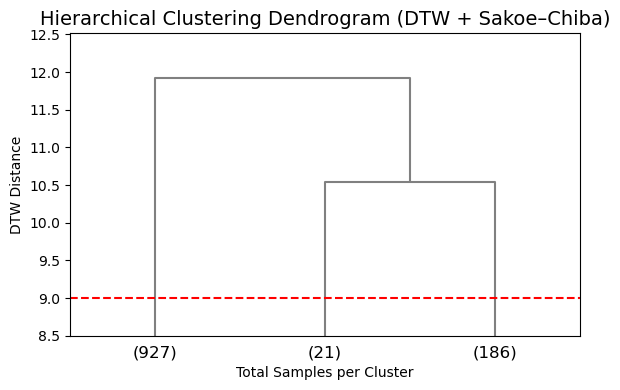

In [20]:
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram, fcluster

# 1. Configuration
distance_threshold = 9
n_clusters = 3

plt.figure(figsize=(6, 4))

# 2. Logic to get labels for the top 3 clusters
def get_top_3_labels(id):
    # n is the number of original samples
    n = len(linked) + 1
    # We only want to label if it is a cluster (merge)
    if id >= n:
        count = int(linked[id - n, 3])
        return f"({count})"
    return ""

# 3. Plotting
# Use p=n_clusters to force the tree to only show those top branches
ddata = dendrogram(
    linked,
    truncate_mode='lastp',
    p=n_clusters, 
    show_leaf_counts=True,
    leaf_label_func=get_top_3_labels,
    color_threshold=distance_threshold,
    above_threshold_color='grey'
)

# 4. Strict visual formatting
plt.axhline(y=distance_threshold, color='red', linestyle='--', label=f'Cut at {distance_threshold}')
plt.ylim(bottom=distance_threshold - 0.5) # Start just below the line for context

plt.title('Hierarchical Clustering Dendrogram (DTW + Sakoe–Chiba)', fontsize=14)
plt.ylabel('DTW Distance')
plt.xlabel('Total Samples per Cluster')

plt.tight_layout()
plt.show()

# 5. Get the actual cluster assignments for your data
cluster_labels = fcluster(linked, t=n_clusters, criterion='maxclust')

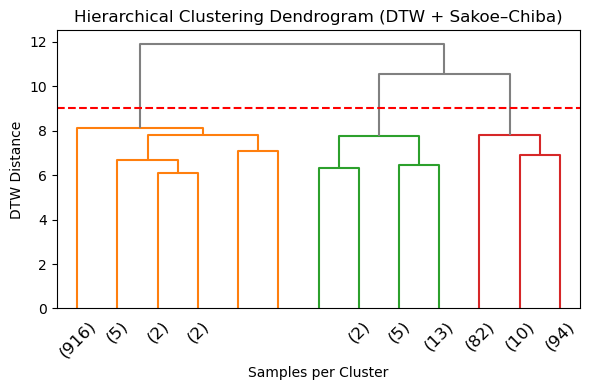

In [25]:
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram, fcluster

# 1. Configuration
distance_threshold = 9  # Moved red line to 3 as requested
n_visible_branches = 13 # Match labels to the 13 branches you counted

plt.figure(figsize=(6, 4))

# 2. Logic to get labels for ONLY the truncated branches
def get_truncated_labels(id):
    # In 'lastp' mode, id reflects the nodes shown in the truncated tree
    # This logic pulls the count for whatever branch is currently being drawn
    n = len(linked) + 1
    if id >= n:
        count = int(linked[id - n, 3])
        return f"({count})"
    return "" # Should not hit this if p is small enough, but keeps it safe

# 3. Plotting
ddata = dendrogram(
    linked,
    truncate_mode='lastp',
    p=n_visible_branches,  # FORCES exactly 13 leaf positions
    show_leaf_counts=True,
    leaf_label_func=get_truncated_labels,
    color_threshold=distance_threshold,
    above_threshold_color='grey'
)

# 4. Formatting
plt.axhline(y=distance_threshold, color='red', linestyle='--', label=f'Cut at {distance_threshold}')

# This ensures we see the branches clearly but keeps the focus above the threshold
plt.ylim(bottom=0) 

plt.title('Hierarchical Clustering Dendrogram (DTW + Sakoe–Chiba)')
plt.ylabel('DTW Distance')
plt.xlabel('Samples per Cluster')

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 5. Assigning these 13 clusters to your data
cluster_labels = fcluster(linked, t=n_visible_branches, criterion='maxclust')

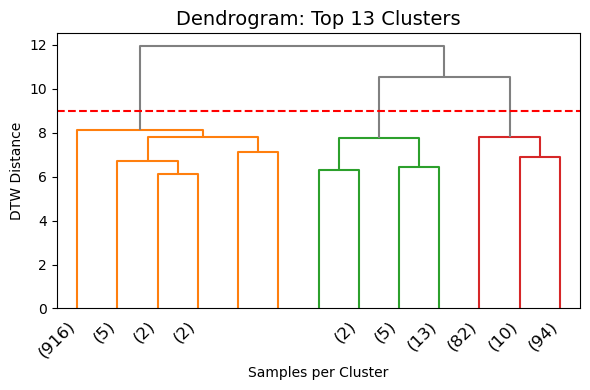

In [27]:
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram

# 1. Configuration
distance_threshold = 9  # Your requested red line height
total_branches = 13     # Force exactly 13 clusters/labels

plt.figure(figsize=(6, 4))

# 2. Labeling function to ensure every branch gets its (size)
def get_cluster_sizes(id):
    n = len(linked) + 1
    # In lastp mode, the id represents the node in the truncated tree
    if id >= n:
        count = int(linked[id - n, 3])
        return f"({count})"
    return "" # Fallback for individual samples if any appear

# 3. Plotting with p=13
ddata = dendrogram(
    linked,
    truncate_mode='lastp',
    p=total_branches,       # This forces exactly 13 leaf positions
    leaf_label_func=get_cluster_sizes,
    color_threshold=distance_threshold,
    above_threshold_color='grey'
)

# 4. Adding the red dotted line at 3
plt.axhline(y=distance_threshold, color='red', linestyle='--', label=f'Cut at {distance_threshold}')

# 5. Formatting the appearance
plt.title(f'Dendrogram: Top {total_branches} Clusters', fontsize=14)
plt.ylabel('DTW Distance')
plt.xlabel('Samples per Cluster')

# Rotate labels and align them so they don't overlap
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

plt.show()

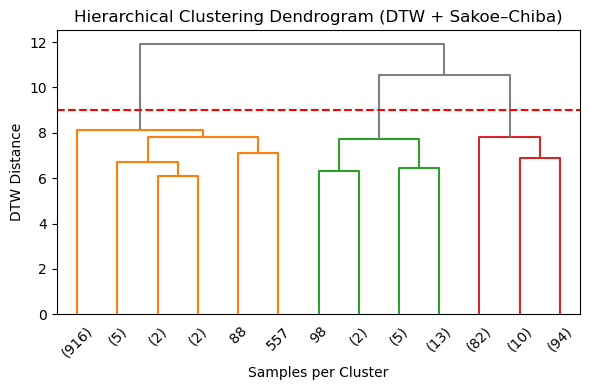

In [29]:
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram

# 1. Configuration
distance_threshold = 9  
total_branches = 13     

plt.figure(figsize=(6, 4)) # Increased width helps labels breathe

# 2. Plotting 
# We remove leaf_label_func and use show_leaf_counts=True 
# which is the native, error-proof way to show (count) for every branch.
ddata = dendrogram(
    linked,
    truncate_mode='lastp',
    p=total_branches,       
    show_leaf_counts=True,  # This natively puts (size) on every branch
    color_threshold=distance_threshold,
    above_threshold_color='grey',
    leaf_rotation=45.,
    leaf_font_size=10.,
)

# 3. Adding the red dotted line at 9
plt.axhline(y=distance_threshold, color='red', linestyle='--')

# 4. Formatting the appearance
plt.title('Hierarchical Clustering Dendrogram (DTW + Sakoe–Chiba)')
plt.ylabel('DTW Distance')
plt.xlabel('Samples per Cluster')

plt.tight_layout()
plt.show()

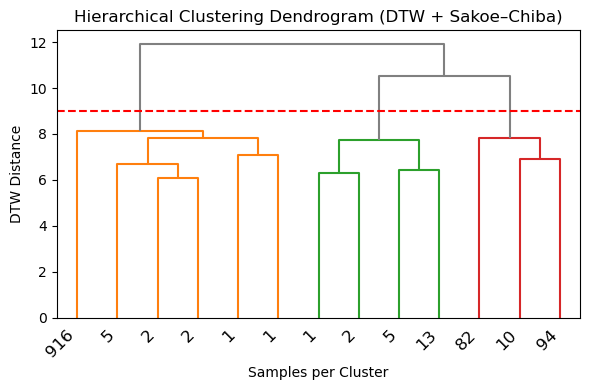

In [32]:
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram

# 1. Configuration
distance_threshold = 9  
total_branches = 13     

plt.figure(figsize=(6, 4))

# 2. Logic to force ALL labels to show as (count)
def get_consistent_labels(id):
    n = len(linked) + 1
    
    # If it's a cluster (merge)
    if id >= n:
        count = int(linked[id - n, 3])
        return f"{count}"
    
    # If it's an individual sample, instead of showing the index, show (1)
    else:
        return "1"

# 3. Plotting
ddata = dendrogram(
    linked,
    truncate_mode='lastp',
    p=total_branches,       # This forces exactly 13 branches
    leaf_label_func=get_consistent_labels,
    color_threshold=distance_threshold,
    above_threshold_color='grey'
)

# 4. Adding the red dotted line at 9
plt.axhline(y=distance_threshold, color='red', linestyle='--')

# 5. Formatting
plt.title('Hierarchical Clustering Dendrogram (DTW + Sakoe–Chiba)')
plt.ylabel('DTW Distance')
plt.xlabel('Samples per Cluster')

plt.xticks(rotation=45, ha='right')
plt.tight_layout()

plt.show()

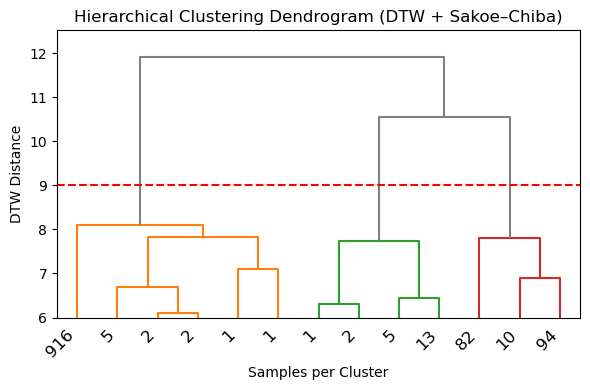

In [34]:
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram

# 1. Configuration
distance_threshold = 9  # Your red line height
y_axis_start = 6        # The "cut" point for the bottom of the figure
total_branches = 13     # Force exactly 13 clusters/labels

plt.figure(figsize=(6, 4))

# 2. Logic to force ALL labels to show as (count)
def get_consistent_labels(id):
    n = len(linked) + 1
    
    # If it's a cluster (merge), return size in brackets
    if id >= n:
        count = int(linked[id - n, 3])
        return f"{count}"
    
    # If it's an individual sample, return (1) to keep format consistent
    else:
        return "1"

# 3. Plotting
ddata = dendrogram(
    linked,
    truncate_mode='lastp',
    p=total_branches,       # Forces exactly 13 branch positions
    leaf_label_func=get_consistent_labels,
    color_threshold=distance_threshold,
    above_threshold_color='grey'
)

# 4. Adding the red dotted line at 9
plt.axhline(y=distance_threshold, color='red', linestyle='--', label=f'Cut at {distance_threshold}')

# 5. Cutting the Y-Axis at 6
# This removes all the messy merges happening near 0
plt.ylim(bottom=y_axis_start) 

# 6. Formatting
plt.title('Hierarchical Clustering Dendrogram (DTW + Sakoe–Chiba)')
plt.ylabel('DTW Distance')
plt.xlabel('Samples per Cluster')

plt.xticks(rotation=45, ha='right')
plt.tight_layout()

plt.show()

<Figure size 1000x600 with 0 Axes>

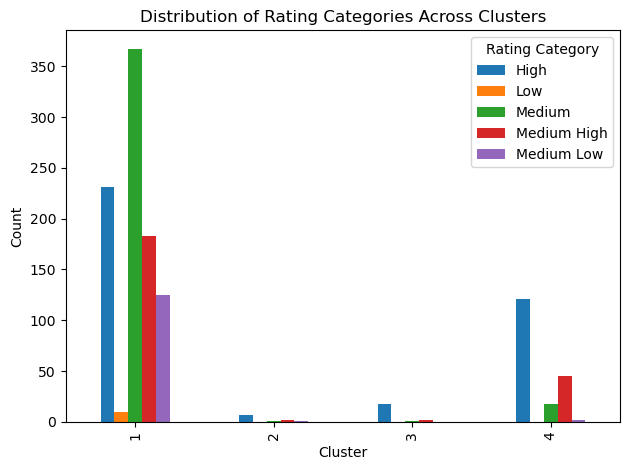

In [5]:
# Add cluster labels to the original dataframe
df['cluster_4'] = cluster_labels

# Compute distribution of rating labels within each cluster
distribution = df.groupby(['cluster_4', 'rating_category']).size().unstack(fill_value=0)

# Plot grouped bar chart
plt.figure(figsize=(10, 6))
distribution.plot(kind='bar', stacked=False)
plt.title('Distribution of Rating Categories Across Clusters')
plt.xlabel('Cluster')
plt.ylabel('Count')
plt.legend(title='Rating Category')
plt.tight_layout()
plt.savefig('rating_distribution_by_cluster.png')

In [6]:
# value counts of cluster labels
unique, counts = np.unique(cluster_labels, return_counts=True)
cluster_distribution = dict(zip(unique, counts))
print("Cluster distribution:", cluster_distribution)
# Show the distribution table
print(distribution)

Cluster distribution: {1: 916, 2: 11, 3: 21, 4: 186}
rating_category  High  Low  Medium  Medium High  Medium Low
cluster_4                                                  
1                 231   10     367          183         125
2                   7    0       1            2           1
3                  18    0       1            2           0
4                 121    0      18           45           2


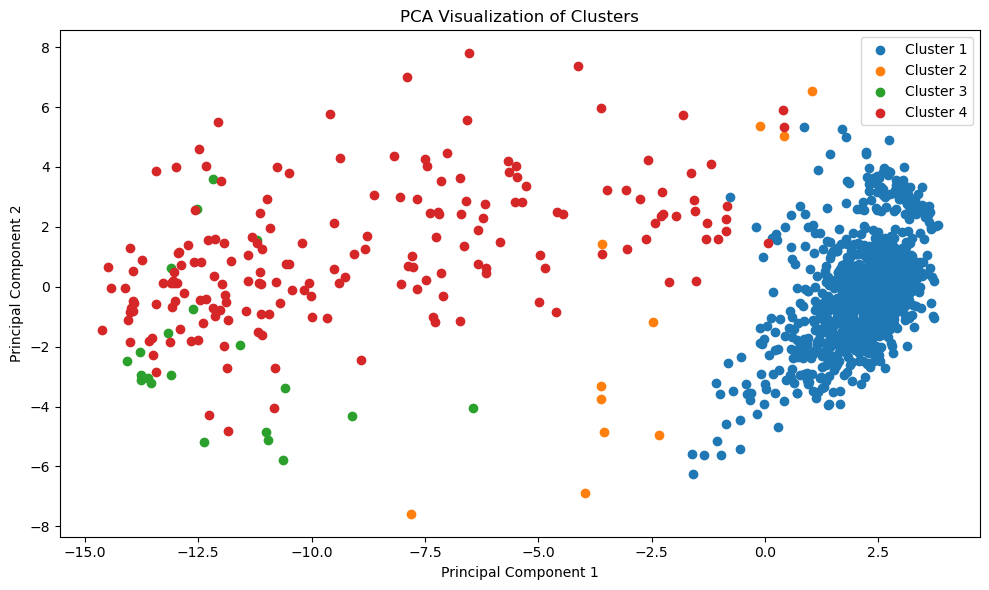

In [7]:
# Apply PCA for dimensionality reduction to 2D
pca = PCA(n_components=2)
pca_results = pca.fit_transform(scaled_data)

# Plot PCA results colored by cluster labels
plt.figure(figsize=(10, 6))
for cluster in np.unique(cluster_labels):
    plt.scatter(pca_results[cluster_labels == cluster, 0],
                pca_results[cluster_labels == cluster, 1],
                label=f'Cluster {cluster}')

plt.title('PCA Visualization of Clusters')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.tight_layout()
plt.savefig('pca_clusters.png')

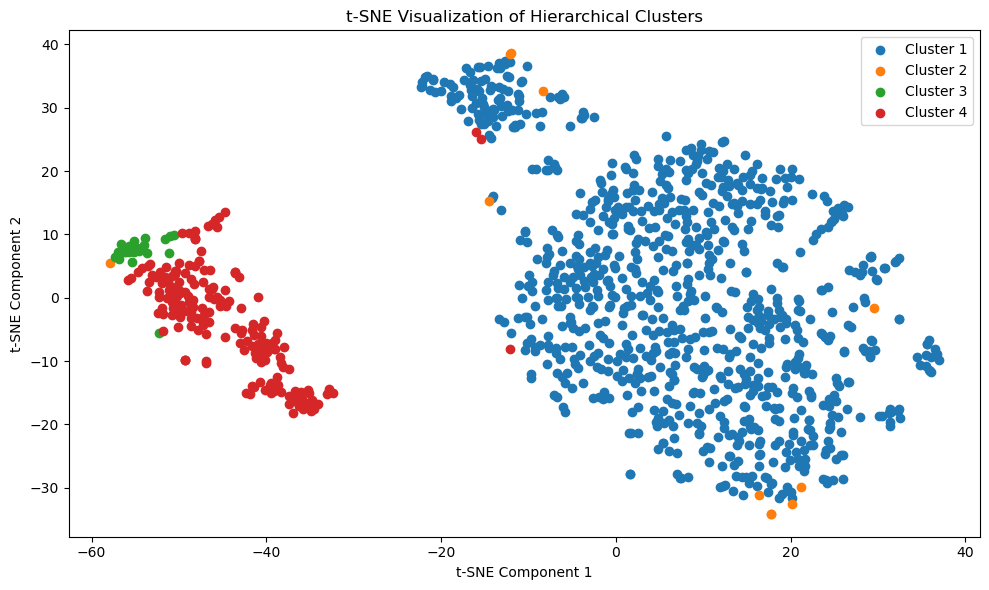

In [8]:

# Apply t-SNE for dimensionality reduction
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
tsne_results = tsne.fit_transform(scaled_data)

# Plot t-SNE results colored by cluster labels
plt.figure(figsize=(10, 6))
for cluster in np.unique(cluster_labels):
    plt.scatter(tsne_results[cluster_labels == cluster, 0],
                tsne_results[cluster_labels == cluster, 1],
                label=f'Cluster {cluster}')

plt.title('t-SNE Visualization of Hierarchical Clusters')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.legend()
plt.tight_layout()
plt.savefig('tsne_hierarchical_clusters.png')

## Cluster = 3

In [9]:
# Assign clusters (e.g., 3 clusters)
cluster_labels = fcluster(linked, t=3, criterion='maxclust')

<Figure size 1000x600 with 0 Axes>

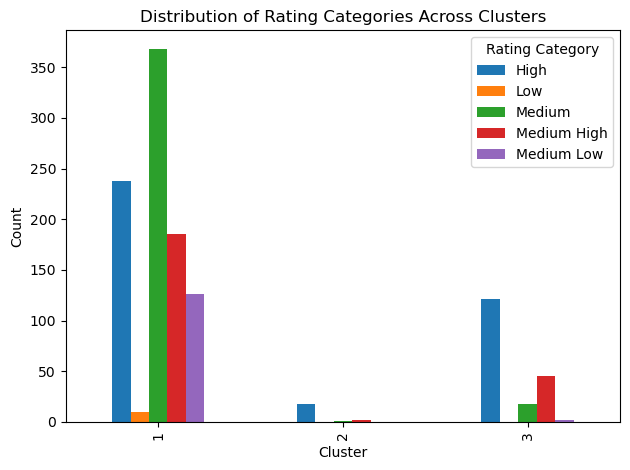

In [10]:
# Add cluster labels to the original dataframe
df['cluster_3'] = cluster_labels

# Compute distribution of rating labels within each cluster
distribution = df.groupby(['cluster_3', 'rating_category']).size().unstack(fill_value=0)

# Plot grouped bar chart
plt.figure(figsize=(10, 6))
distribution.plot(kind='bar', stacked=False)
plt.title('Distribution of Rating Categories Across Clusters')
plt.xlabel('Cluster')
plt.ylabel('Count')
plt.legend(title='Rating Category')
plt.tight_layout()
plt.savefig('rating_distribution_by_cluster.png')

In [11]:
# value counts of cluster labels
unique, counts = np.unique(cluster_labels, return_counts=True)
cluster_distribution = dict(zip(unique, counts))
print("Cluster distribution:", cluster_distribution)

Cluster distribution: {1: 927, 2: 21, 3: 186}


In [12]:
# Show the distribution table
print(distribution)

rating_category  High  Low  Medium  Medium High  Medium Low
cluster_3                                                  
1                 238   10     368          185         126
2                  18    0       1            2           0
3                 121    0      18           45           2


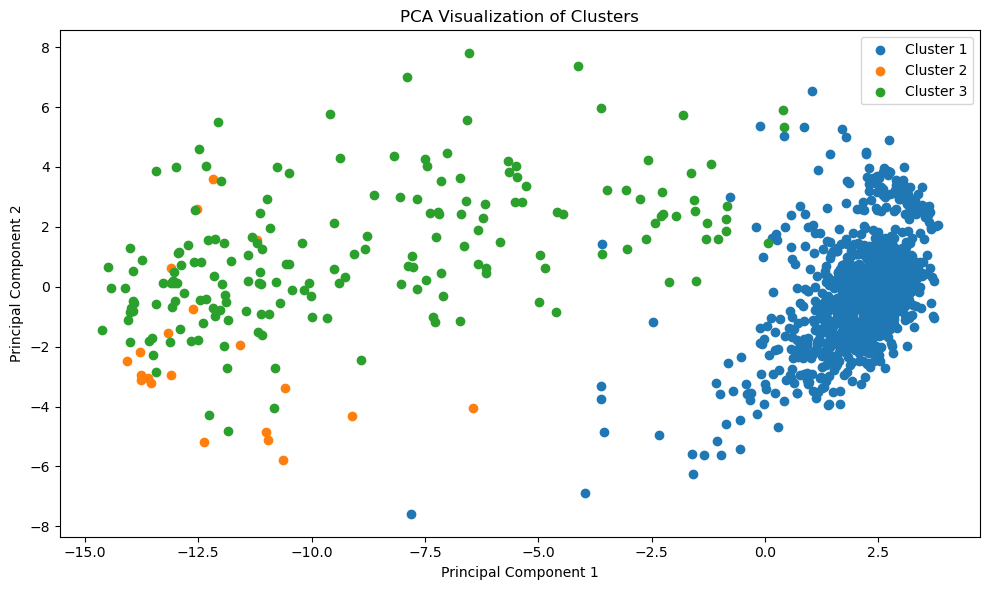

In [13]:
# Apply PCA for dimensionality reduction to 2D
pca = PCA(n_components=2)
pca_results = pca.fit_transform(scaled_data)

# Plot PCA results colored by cluster labels
plt.figure(figsize=(10, 6))
for cluster in np.unique(cluster_labels):
    plt.scatter(pca_results[cluster_labels == cluster, 0],
                pca_results[cluster_labels == cluster, 1],
                label=f'Cluster {cluster}')

plt.title('PCA Visualization of Clusters')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.tight_layout()
plt.savefig('pca_clusters.png')

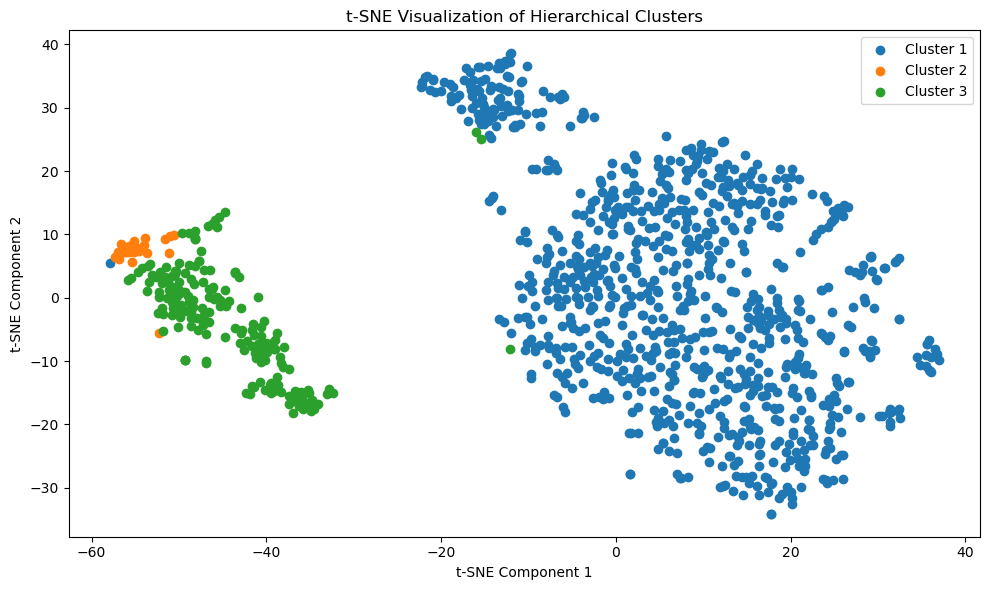

In [14]:

# Apply t-SNE for dimensionality reduction
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
tsne_results = tsne.fit_transform(scaled_data)

# Plot t-SNE results colored by cluster labels
plt.figure(figsize=(10, 6))
for cluster in np.unique(cluster_labels):
    plt.scatter(tsne_results[cluster_labels == cluster, 0],
                tsne_results[cluster_labels == cluster, 1],
                label=f'Cluster {cluster}')

plt.title('t-SNE Visualization of Hierarchical Clusters')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.legend()
plt.tight_layout()
plt.savefig('tsne_hierarchical_clusters.png')

## Cluster = 5

In [15]:
# Assign clusters (e.g., 6 clusters)
cluster_labels = fcluster(linked, t=5, criterion='maxclust')

<Figure size 1000x600 with 0 Axes>

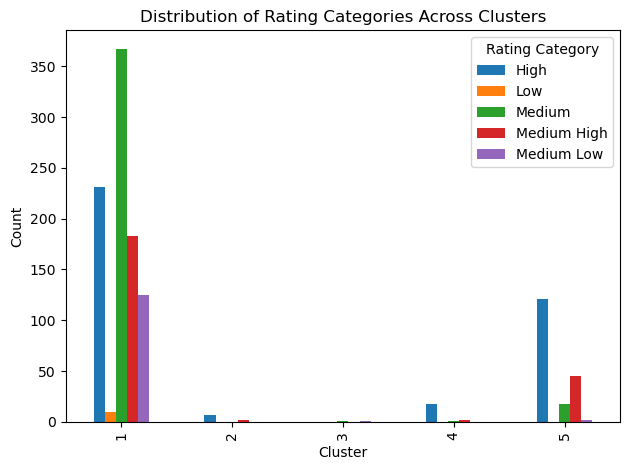

In [16]:
# Add cluster labels to the original dataframe
df['cluster_5'] = cluster_labels

# Compute distribution of rating labels within each cluster
distribution = df.groupby(['cluster_5', 'rating_category']).size().unstack(fill_value=0)

# Plot grouped bar chart
plt.figure(figsize=(10, 6))
distribution.plot(kind='bar', stacked=False)
plt.title('Distribution of Rating Categories Across Clusters')
plt.xlabel('Cluster')
plt.ylabel('Count')
plt.legend(title='Rating Category')
plt.tight_layout()
plt.savefig('rating_distribution_by_cluster.png')

In [17]:
# value counts of cluster labels
unique, counts = np.unique(cluster_labels, return_counts=True)
cluster_distribution = dict(zip(unique, counts))
print("Cluster distribution:", cluster_distribution)
# Show the distribution table
print(distribution)

Cluster distribution: {1: 916, 2: 9, 3: 2, 4: 21, 5: 186}
rating_category  High  Low  Medium  Medium High  Medium Low
cluster_5                                                  
1                 231   10     367          183         125
2                   7    0       0            2           0
3                   0    0       1            0           1
4                  18    0       1            2           0
5                 121    0      18           45           2


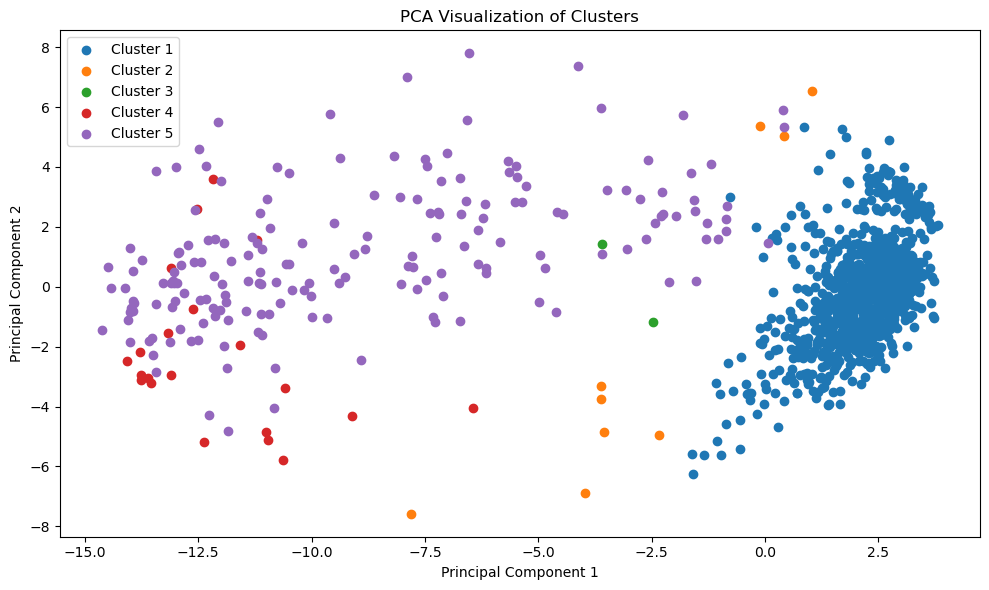

In [18]:
# Apply PCA for dimensionality reduction to 2D
pca = PCA(n_components=2)
pca_results = pca.fit_transform(scaled_data)

# Plot PCA results colored by cluster labels
plt.figure(figsize=(10, 6))
for cluster in np.unique(cluster_labels):
    plt.scatter(pca_results[cluster_labels == cluster, 0],
                pca_results[cluster_labels == cluster, 1],
                label=f'Cluster {cluster}')

plt.title('PCA Visualization of Clusters')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.tight_layout()
plt.savefig('pca_clusters.png')

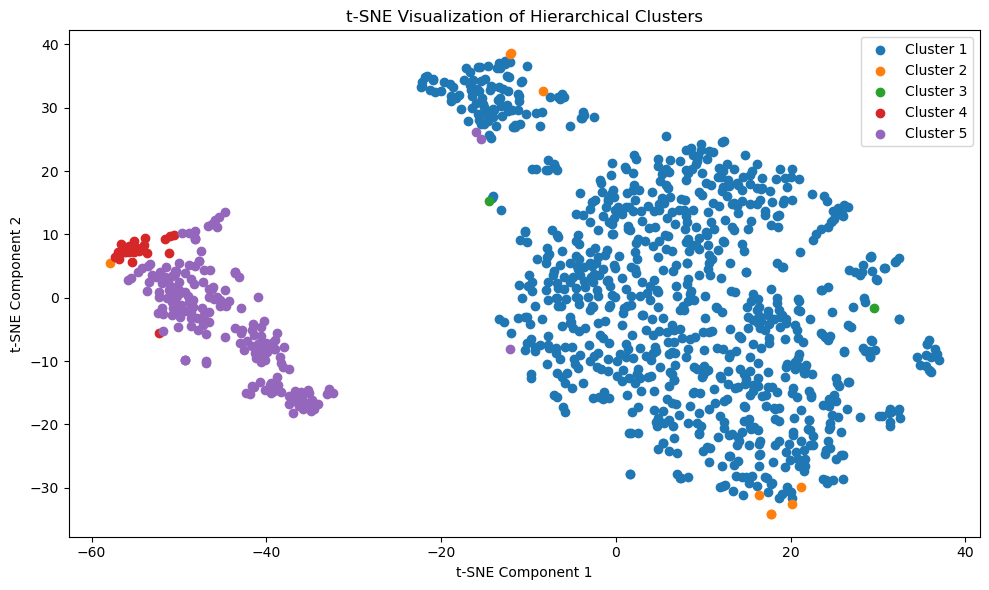

In [19]:
# Apply t-SNE for dimensionality reduction
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
tsne_results = tsne.fit_transform(scaled_data)

# Plot t-SNE results colored by cluster labels
plt.figure(figsize=(10, 6))
for cluster in np.unique(cluster_labels):
    plt.scatter(tsne_results[cluster_labels == cluster, 0],
                tsne_results[cluster_labels == cluster, 1],
                label=f'Cluster {cluster}')

plt.title('t-SNE Visualization of Hierarchical Clusters')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.legend()
plt.tight_layout()
plt.savefig('tsne_hierarchical_clusters.png')

## Cluster = 8

In [20]:
# Assign clusters (e.g., 8 clusters)
cluster_labels = fcluster(linked, t=8, criterion='maxclust')

<Figure size 1000x600 with 0 Axes>

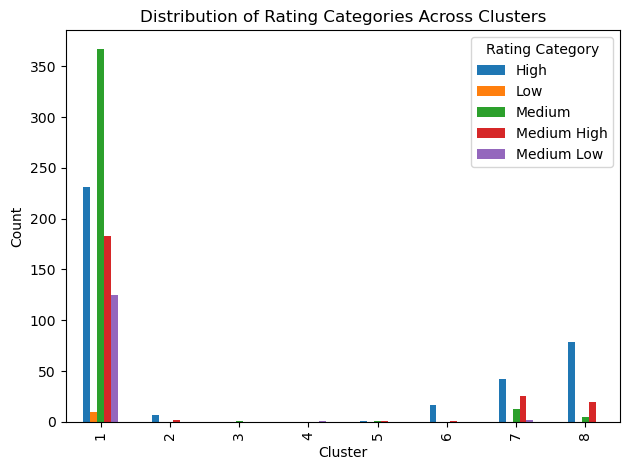

In [21]:
# Add cluster labels to the original dataframe
df['cluster_8'] = cluster_labels

# Compute distribution of rating labels within each cluster
distribution = df.groupby(['cluster_8', 'rating_category']).size().unstack(fill_value=0)

# Plot grouped bar chart
plt.figure(figsize=(10, 6))
distribution.plot(kind='bar', stacked=False)
plt.title('Distribution of Rating Categories Across Clusters')
plt.xlabel('Cluster')
plt.ylabel('Count')
plt.legend(title='Rating Category')
plt.tight_layout()
plt.savefig('rating_distribution_by_cluster.png')

In [22]:
# value counts of cluster labels
unique, counts = np.unique(cluster_labels, return_counts=True)
cluster_distribution = dict(zip(unique, counts))
print("Cluster distribution:", cluster_distribution)
# Show the distribution table
print(distribution)

Cluster distribution: {1: 916, 2: 9, 3: 1, 4: 1, 5: 3, 6: 18, 7: 82, 8: 104}
rating_category  High  Low  Medium  Medium High  Medium Low
cluster_8                                                  
1                 231   10     367          183         125
2                   7    0       0            2           0
3                   0    0       1            0           0
4                   0    0       0            0           1
5                   1    0       1            1           0
6                  17    0       0            1           0
7                  42    0      13           25           2
8                  79    0       5           20           0


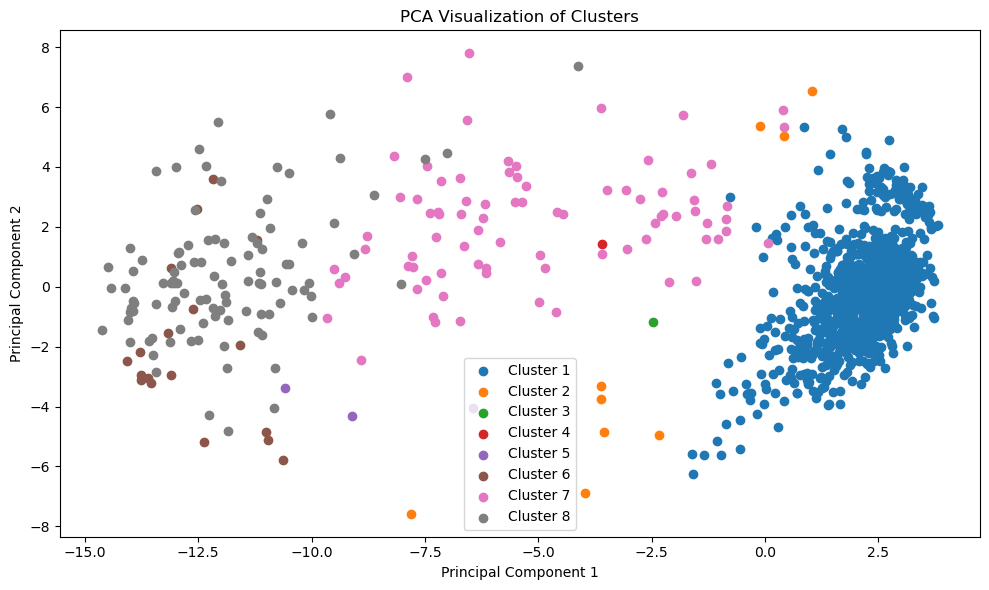

In [23]:
# Apply PCA for dimensionality reduction to 2D
pca = PCA(n_components=2)
pca_results = pca.fit_transform(scaled_data)

# Plot PCA results colored by cluster labels
plt.figure(figsize=(10, 6))
for cluster in np.unique(cluster_labels):
    plt.scatter(pca_results[cluster_labels == cluster, 0],
                pca_results[cluster_labels == cluster, 1],
                label=f'Cluster {cluster}')

plt.title('PCA Visualization of Clusters')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.tight_layout()
plt.savefig('pca_clusters.png')

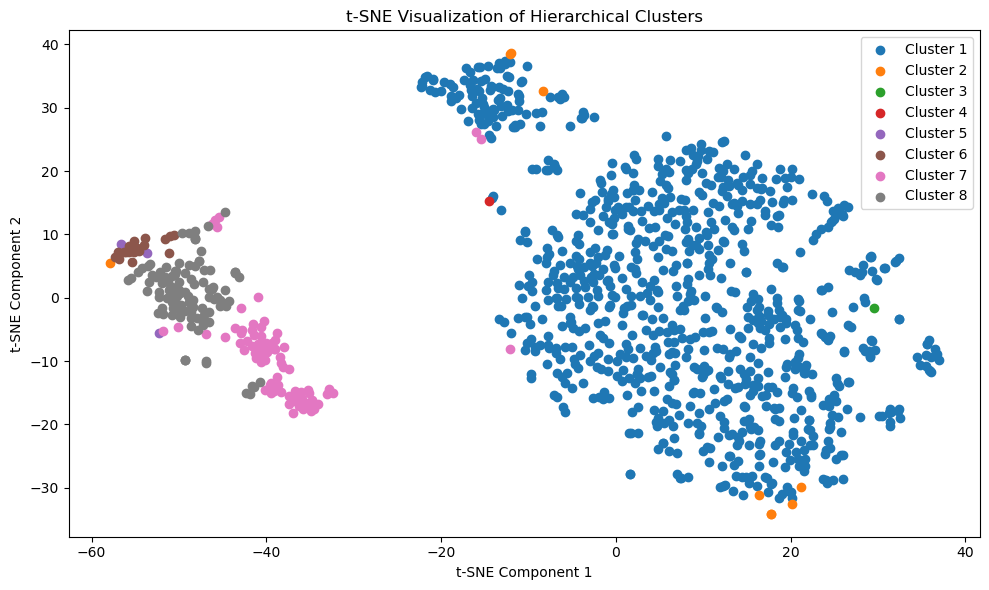

In [24]:
# Apply t-SNE for dimensionality reduction
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
tsne_results = tsne.fit_transform(scaled_data)

# Plot t-SNE results colored by cluster labels
plt.figure(figsize=(10, 6))
for cluster in np.unique(cluster_labels):
    plt.scatter(tsne_results[cluster_labels == cluster, 0],
                tsne_results[cluster_labels == cluster, 1],
                label=f'Cluster {cluster}')

plt.title('t-SNE Visualization of Hierarchical Clusters')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.legend()
plt.tight_layout()
plt.savefig('tsne_hierarchical_clusters.png')